In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import datetime as dt
import os
import pickle
import scipy
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from yellowbrick.classifier import roc_auc
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import SGDClassifier
#from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
sns.set_style('dark')
%matplotlib inline
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abhis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        stemmer = SnowballStemmer("english", ignore_stopwords=True)
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

In [3]:
# This function will provide result to our classification model
def validate_result(y_true, y_pred,y_prob,model="Model"):
    print(f"\nThe Result for the {model} Classification is as follows\n")
    print("=="*50)
    print(f"Recall Score: {(recall_score(y_true, y_pred,average='weighted')*100).round(3)} %")
    print(f"Precision Score: {(precision_score(y_true, y_pred,average='weighted')*100).round(3)} %")
    print("F1 Score: ",f1_score(y_true, y_pred,average='weighted').round(3))
    print("Log Loss: ",log_loss(y_true, y_prob).round(3))

In [19]:
data = pd.read_csv('./dataset/mozilla_bugs.csv')

In [5]:
data.head()

,Type,Summary,Product,Component,Priority,Classification,Team Name
0,defect,[trunk] Crash on startup (mozilla::ReadAheadLi...,Firefox,General,P1,Client Software,Frontend
1,defect,release-update-verify-config tasks failing for...,Release Engineering,Release Automation: Updates,P1,Other,RelEng
2,defect,Android workers not taking jobs.,Taskcluster,General,P1,Other,Mozilla
3,defect,browser/base/content/test/performance/browser_...,NSS,Libraries,P1,Components,Crypto
4,defect,Breakpoint positions are only fetched for some...,DevTools,Debugger,P1,Components,DevTools


In [9]:
data.shape #30000 records in total and 7 attributes

(30000, 7)

In [10]:
data.columns

Index(['Type', 'Summary', 'Product', 'Component', 'Priority', 'Classification',
       'Team Name'],
      dtype='object')

### Base Model Building And Prediction


#### Here we will use Logistic Regression with SGDClassifier for classification.

#### In addition to Team Name, we will also try to determine  Component and Classification based on the textual summary of the reported bug

#### We will create individual models for the same and test it out on Real World data for prediction

## Model Building (Logistic Regression with RandomizedSearch)

Logistic Regression to fit the typical sigmoid hypothesis form can be done with SGDClassifier wherein you specify the specific loss function and penalty, and it will always use stochastic gradient descent for the optimization.

In [11]:
def build_model(data,column_to_predict,remove_stop_words,stop_words_lang,use_stemming,fit_prior,min_data_per_class,text_columns):
    print("Shape of dataset before removing classes with less then " + str(min_data_per_class) + " rows: "+str(data.shape))
    print("Number of classes before removing classes with less then " + str(min_data_per_class) + " rows: "+str(len(np.unique(data[column_to_predict]))))
    bytag = data.groupby(column_to_predict).aggregate(np.count_nonzero)
    tags = bytag[bytag.Summary > min_data_per_class].index
    data = data[data[column_to_predict].isin(tags)]
    print(
            "Shape of dataset after removing classes with less then "
            + str(min_data_per_class) + " rows: "
            + str(data.shape)
        )
    print(
            "Number of classes after removing classes with less then "
            + str(min_data_per_class) + " rows: "
            + str(len(np.unique(data[column_to_predict])))
        )

    labelData = data[column_to_predict]
    data = data[text_columns]



    # Split dataset into training and testing data
    train_data, test_data, train_labels, test_labels = train_test_split(
        data, labelData, test_size=0.2
    )  # split data to train/test sets with 80:20 ratio

    # Extracting features from text
    # Count vectorizer
    if remove_stop_words:
        count_vect = CountVectorizer(stop_words=stop_words_lang)
    elif use_stemming:
        count_vect = StemmedCountVectorizer(stop_words=stop_words_lang)
    else:
        count_vect = CountVectorizer()

    # Fitting the training data into a data processing pipeline and eventually into the model itself

    text_clf = Pipeline([
        ('vect', count_vect),
        ('tfidf', TfidfTransformer()),
        ('clf', SGDClassifier(loss='log',early_stopping=True))])
    
    
    text_clf = text_clf.fit(train_data, train_labels)

    #print(text_clf.get_params().keys())
    if use_random_search:
        # use_random_search
        # Here, we are creating a list of parameters for which we would like to do performance tuning.
        # All the parameters name start with the classifier name (remember the arbitrary name we gave).
        # E.g. vect__ngram_range; here we are telling to use unigram and bigrams and choose the one which is optimal.


        # LR parameters
        param = {'clf__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],'clf__penalty': ['l2','l1']}


        # Next, we create an instance of the grid search by passing the classifier, parameters
        # and n_jobs=-1 which tells to use multiple cores from user machine.
        rs_clf = RandomizedSearchCV(text_clf, param, n_jobs=-1, verbose=50,return_train_score=True,scoring='f1_macro',cv=5)
        rs_clf = rs_clf.fit(train_data, train_labels)

        # To see the best mean score and the params, run the following code
        print("Best Score:",rs_clf.best_score_)
        print("Best Params:", rs_clf.best_params_)
        print("Best Estimator:", rs_clf.best_estimator_)
        

    print("Evaluating model")
    # Score and evaluate model on test data using model without hyperparameter tuning
    predicted = text_clf.predict(test_data)
    prediction_acc = np.mean(predicted == test_labels)
    print("Confusion matrix without RandomizedSearch:")
    print(metrics.confusion_matrix(test_labels, predicted))
    print("Mean without RandomizedSearch: " + str(prediction_acc))
    
    
    # Score and evaluate model on test data using model WITH hyperparameter tuning
    if use_random_search:
        predicted = rs_clf.predict(test_data)
        prediction_acc = np.mean(predicted == test_labels)
        print("Confusion matrix with RandomizedSearch:")
        print(metrics.confusion_matrix(test_labels, predicted))
        print("Mean with RandomizedSearch: " + str(prediction_acc))
    
    validate_result(test_labels,text_clf.predict(test_data),text_clf.predict_proba(test_data),model="RF")
    # Ploting confusion matrix with 'seaborn' module

    mat = confusion_matrix(test_labels, predicted)
    plt.figure(figsize=(10, 10))
    sns.set()
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=np.unique(test_labels),
                yticklabels=np.unique(test_labels))
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    # Save confusion matrix to outputs folder
    # plt.savefig(os.path.join('.', 'outputs', 'confusion_matrix.png'))
    plt.show()
    
    
    # Printing classification report
    # Use below line only with Jupyter Notebook

    print(classification_report(test_labels, predicted,
                                target_names=np.unique(test_labels)))
    
    
    # Save trained models to /output folder
    if use_random_search:
        pickle.dump(
            rs_clf,
            open(os.path.join(
                '.', 'outputs', column_to_predict+"_LR_RS.model"),
                'wb'
            )
        )
    else:
        pickle.dump(
            text_clf,
            open(os.path.join(
                '.', 'outputs', column_to_predict+"_LR_RS.model"),
                'wb'
            )
        )


#### Build the model to predict Team Name

In [20]:
df2 = data.copy() #Keep a copy of original dataframe to ensure it can be used later. Dataframe data to be fed to the method

#Initialize parameters to be fed to the method for model building
column_to_predict = "Team Name"

use_random_search = True  # grid search is used to find hyperparameters. Searching for hyperparameters is time consuming
remove_stop_words = False  # removes stop words from processed text
stop_words_lang = 'english'  # used with 'remove_stop_words' and defines language of stop words collection
use_stemming = True  # word stemming using nltk
fit_prior = True  # if use_stemming == True then it should be set to False ?? double check
min_data_per_class = 100  # used to determine number of samples required for each class.Classes with less than that will be excluded from the dataset. default value is 1


text_columns = "Summary" #text columns used for TF-IDF

Shape of dataset before removing classes with less then 100 rows: (30000, 7)
Number of classes before removing classes with less then 100 rows: 31
Shape of dataset after removing classes with less then 100 rows: (29848, 7)
Number of classes after removing classes with less then 100 rows: 27
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Score: 0.40766479437306946
Best Params: {'clf__penalty': 'l2', 'clf__alpha': 0.0001}
Best Estimator: Pipeline(steps=[('vect', StemmedCountVectorizer(stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(early_stopping=True, loss='log'))])
Evaluating model
Confusion matrix without RandomizedSearch:
[[ 10   0   0   0   3   0   0   7   2   0   6   0   0   2  48   0   2   0
    1   0   0   0   1   0   0   2   0]
 [  0  46   0   1   0   0   0  10   2   0  11   0   1   2  76   0   2   0
    7   0   0   0   1   0   0   0   0]
 [  0   0   2   0   2   0   0   5   1   0   9   1   0   0  31 

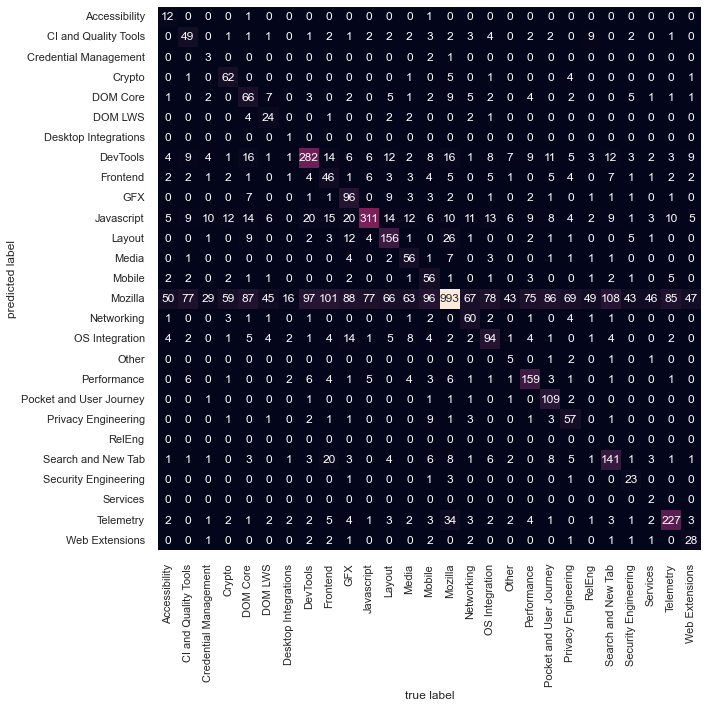

                         precision    recall  f1-score   support

          Accessibility       0.86      0.14      0.24        84
   CI and Quality Tools       0.54      0.31      0.39       159
  Credential Management       0.50      0.06      0.10        54
                 Crypto       0.83      0.42      0.56       147
               DOM Core       0.55      0.30      0.39       217
                DOM LWS       0.67      0.26      0.37        93
   Desktop Integrations       1.00      0.04      0.07        26
               DevTools       0.62      0.66      0.64       428
               Frontend       0.42      0.21      0.28       219
                    GFX       0.74      0.37      0.50       257
             Javascript       0.57      0.75      0.65       413
                 Layout       0.69      0.55      0.61       283
                  Media       0.72      0.35      0.47       162
                 Mobile       0.69      0.26      0.38       213
                Mozilla 

In [13]:
#Build Model
build_model(data, column_to_predict,remove_stop_words,stop_words_lang,use_stemming,fit_prior,min_data_per_class,text_columns)

In [14]:
#Load Model
model_Team_Name = pickle.load(
    open(
         os.getcwd()+"/outputs/Team Name_LR_RS.model", "rb"
    )
)

#### Build the Model to predict Component

In [15]:
data = df2.copy() #restore original dataframe which got modified while creating last model
#Initialize parameters to be fed to the method for model building
column_to_predict = "Component"

use_random_search = True  # grid search is used to find hyperparameters. Searching for hyperparameters is time consuming
remove_stop_words = False  # removes stop words from processed text
stop_words_lang = 'english'  # used with 'remove_stop_words' and defines language of stop words collection
use_stemming = True  # word stemming using nltk
fit_prior = True  # if use_stemming == True then it should be set to False ?? double check
min_data_per_class = 50  # used to determine number of samples required for each class.Classes with less than that will be excluded from the dataset. default value is 1


text_columns = "Summary" #text columns used for TF-IDF

Shape of dataset before removing classes with less then 50 rows: (30000, 7)
Number of classes before removing classes with less then 50 rows: 536
Shape of dataset after removing classes with less then 50 rows: (24724, 7)
Number of classes after removing classes with less then 50 rows: 126
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Score: 0.033258975687758055
Best Params: {'clf__penalty': 'l2', 'clf__alpha': 0.001}
Best Estimator: Pipeline(steps=[('vect', StemmedCountVectorizer(stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 SGDClassifier(alpha=0.001, early_stopping=True, loss='log'))])
Evaluating model
Confusion matrix without RandomizedSearch:
[[  0   0   0 ...   0   0   0]
 [  0   2   0 ...   0   0   0]
 [  0   0  51 ...   0   0   0]
 ...
 [  0   0   0 ...  11   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0 134]]
Mean without RandomizedSearch: 0.4155712841253792
Confusion matrix w

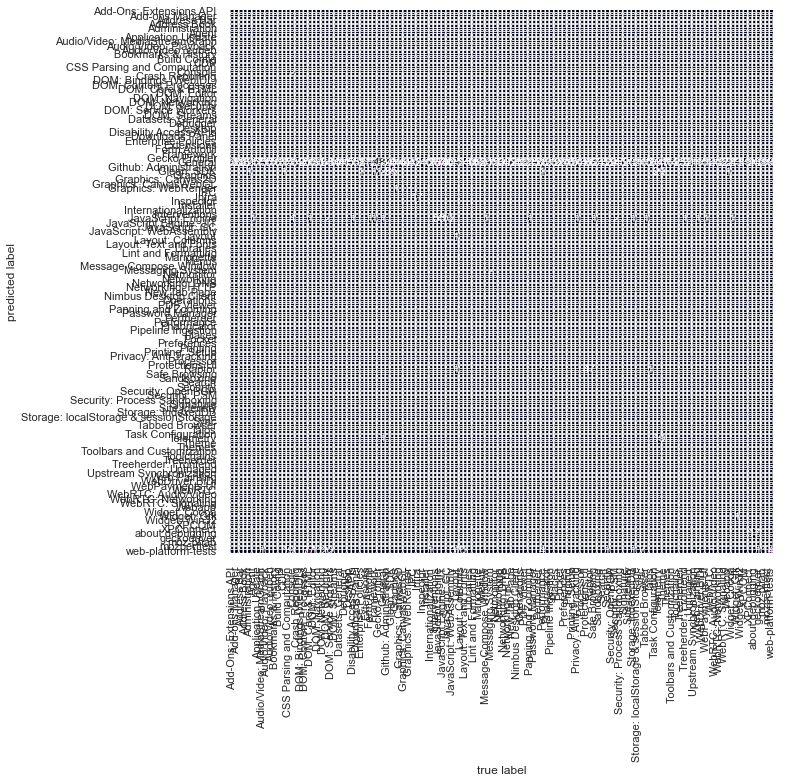

                                        precision    recall  f1-score   support

               Add-Ons: Extensions API       0.00      0.00      0.00        10
                       Add-ons Manager       0.00      0.00      0.00        20
                           Address Bar       0.00      0.00      0.00        82
                          Address Book       0.00      0.00      0.00        16
                        Administration       0.00      0.00      0.00        32
                                 Agent       0.00      0.00      0.00        26
                    Application Update       0.00      0.00      0.00        17
         Audio/Video: MediaStreamGraph       0.00      0.00      0.00        14
                 Audio/Video: Playback       0.00      0.00      0.00        55
                    Audio/Video: cubeb       0.00      0.00      0.00        15
                   Bookmarks & History       0.00      0.00      0.00        16
                          Build Config 

In [16]:
#Build Model
build_model(data, column_to_predict,remove_stop_words,stop_words_lang,use_stemming,fit_prior,min_data_per_class,text_columns)

In [14]:
#Load Model
model_Component = pickle.load(
    open(
         os.getcwd()+"/outputs/Component_LR_RS.model", "rb"
    )
)

#### Build Model to predict Classification

In [21]:
data = df2.copy() #restore original dataframe which got modified while creating last model
#Initialize parameters to be fed to the method for model building
column_to_predict = "Classification"


use_random_search = True  # grid search is used to find hyperparameters. Searching for hyperparameters is time consuming
remove_stop_words = False  # removes stop words from processed text
stop_words_lang = 'english'  # used with 'remove_stop_words' and defines language of stop words collection
use_stemming = True  # word stemming using nltk
fit_prior = True  # if use_stemming == True then it should be set to False ?? double check
min_data_per_class = 10  # used to determine number of samples required for each class.Classes with less than that will be excluded from the dataset. default value is 1


text_columns = "Summary" #text columns used for TF-IDF

Shape of dataset before removing classes with less then 10 rows: (30000, 7)
Number of classes before removing classes with less then 10 rows: 5
Shape of dataset after removing classes with less then 10 rows: (30000, 7)
Number of classes after removing classes with less then 10 rows: 5
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Score: 0.49185028286195553
Best Params: {'clf__penalty': 'l2', 'clf__alpha': 0.0001}
Best Estimator: Pipeline(steps=[('vect', StemmedCountVectorizer(stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(early_stopping=True, loss='log'))])
Evaluating model
Confusion matrix without RandomizedSearch:
[[ 794  681    4    0    1]
 [ 163 3657    8    0    0]
 [  37  255   98    1    0]
 [  28   98    3   17    0]
 [  13   92    1    0   49]]
Mean without RandomizedSearch: 0.7691666666666667
Confusion matrix with RandomizedSearch:
[[ 783  693    3    0    1]
 [ 157 3664    7    0    0]
 [  37 

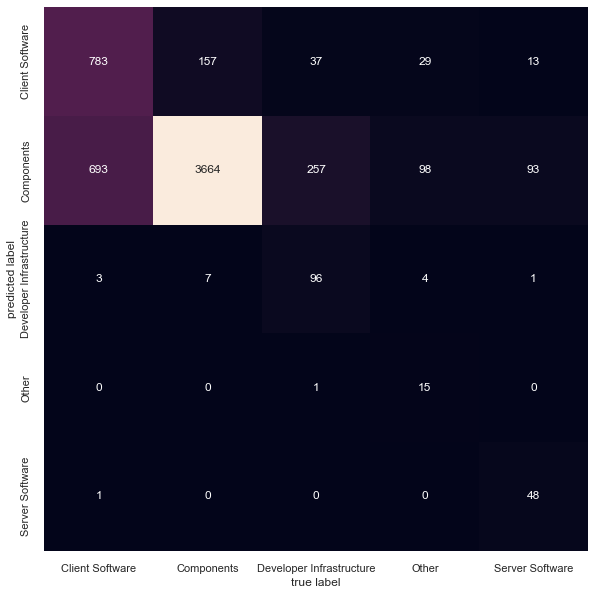

                          precision    recall  f1-score   support

         Client Software       0.77      0.53      0.63      1480
              Components       0.76      0.96      0.85      3828
Developer Infrastructure       0.86      0.25      0.38       391
                   Other       0.94      0.10      0.19       146
         Server Software       0.98      0.31      0.47       155

                accuracy                           0.77      6000
               macro avg       0.86      0.43      0.50      6000
            weighted avg       0.78      0.77      0.74      6000



In [22]:
#Build Model
build_model(data, column_to_predict,remove_stop_words,stop_words_lang,use_stemming,fit_prior,min_data_per_class,text_columns)

In [23]:
#Load Model
model_Classification = pickle.load(
    open(
         os.getcwd()+"/outputs/Classification_LR_RS.model", "rb"
    )
)

#### Feed Random problem summary of support tickets to test predictions by the pre-trained models.

In [24]:
#Random sample input texts 'summarizing the issue' and fed to the models for testing
description1='Sync error while signing in to profile'
description2='details not appearing on locked device'
description3='Crash on toggle of settings on iPad'
description4='Unable to save credentials for email'
description5='Browser keeps crashing on opening multiple tabs' 
description6='Themes resulting in modified colors on the menubar'

In [25]:
#Team Name Model
predicted = model_Team_Name.predict([description1])
print("Predicted Team Name: " + str(predicted))
predicted = model_Team_Name.predict([description2])
print("Predicted Team Name: " + str(predicted))
predicted = model_Team_Name.predict([description3])
print("Predicted Team Name: " + str(predicted))
predicted = model_Team_Name.predict([description4])
print("Predicted Team Name: " + str(predicted))
predicted = model_Team_Name.predict([description5])
print("Predicted Team Name: " + str(predicted))
predicted = model_Team_Name.predict([description6])
print("Predicted Team Name: " + str(predicted))

Predicted Team Name: ['Performance']
Predicted Team Name: ['Mozilla']
Predicted Team Name: ['Mobile']
Predicted Team Name: ['Mozilla']
Predicted Team Name: ['Search and New Tab']
Predicted Team Name: ['Search and New Tab']


In [26]:
#Component Model
predicted = model_Component.predict([description1])
print("Predicted Component: " + str(predicted))
predicted = model_Component.predict([description2])
print("Predicted Component: " + str(predicted))
predicted = model_Component.predict([description3])
print("Predicted Component: " + str(predicted))
predicted = model_Component.predict([description4])
print("Predicted Component: " + str(predicted))
predicted = model_Component.predict([description5])
print("Predicted Component: " + str(predicted))
predicted = model_Component.predict([description6])
print("Predicted Component: " + str(predicted))

NameError: name 'model_Component' is not defined

In [27]:
#Classification Model
predicted = model_Classification.predict([description1])
print("Predicted Classification: " + str(predicted))
predicted = model_Classification.predict([description2])
print("Predicted Classification: " + str(predicted))
predicted = model_Classification.predict([description3])
print("Predicted Classification: " + str(predicted))
predicted = model_Classification.predict([description4])
print("Predicted Classification: " + str(predicted))
predicted = model_Classification.predict([description5])
print("Predicted Classification: " + str(predicted))
predicted = model_Classification.predict([description6])
print("Predicted Classification: " + str(predicted))

Predicted Classification: ['Components']
Predicted Classification: ['Components']
Predicted Classification: ['Components']
Predicted Classification: ['Client Software']
Predicted Classification: ['Components']
Predicted Classification: ['Components']
